In [1]:
import tarfile
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy)

from ema_workbench import Samplers

from ema_workbench import load_results

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

import copy

In [2]:
#results = load_results("results/dike_model_test_sobol_do_nothing.tar.gz")
#results = load_results("results/dike_model_test_sobol_4_policies.tar.gz")
results = load_results("results/dike_model_test_sobol_policies_example_policies.tar.gz")
experiments, outcomes = results

In [3]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())
experiments.head()


dict_keys(['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,102,249.140533,1.5,0.514005,85.84293,10.0,0.95725,288.778003,10.0,0.677527,...,0,0,0,0,0,0,0,0,policy 1,dikesnet
1,112,249.140533,1.5,0.514005,85.84293,10.0,0.95725,288.778003,10.0,0.677527,...,0,0,0,0,0,0,0,1,policy 1,dikesnet
2,102,215.138074,1.5,0.514005,85.84293,10.0,0.95725,288.778003,10.0,0.677527,...,0,0,0,0,0,0,0,2,policy 1,dikesnet
3,102,249.140533,1.5,0.514005,85.84293,10.0,0.95725,288.778003,10.0,0.677527,...,0,0,0,0,0,0,0,3,policy 1,dikesnet
4,102,249.140533,1.5,0.710694,85.84293,10.0,0.95725,288.778003,10.0,0.677527,...,0,0,0,0,0,0,0,4,policy 1,dikesnet


In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(5)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)


In [27]:
kpi_list=list(outcomes.keys())
ooi=kpi_list[5]
print(kpi_list)
print(ooi)

['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
A.2_Expected Number of Deaths


In [28]:
outcomes[ooi][:,0]

array([0.00331232, 0.00455995, 0.00238619, ..., 0.03590493, 0.03656499,
       0.03854818])

In [29]:
def analyze(results, kpi,planning_step):
    """analyze results using SALib sobol, returns a dataframe"""
    _, outcomes = results
    
    problem = get_SALib_problem(dike_model.uncertainties)
    y = outcomes[kpi][:,planning_step]
    sobol_indices = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
    sobol_stats = {key: sobol_indices[key] for key in ["ST", "ST_conf", "S1", "S1_conf"]}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem["names"])
    sobol_stats.sort_values(by="ST", ascending=False)
    s2 = pd.DataFrame(sobol_indices["S2"], index=problem["names"], columns=problem["names"])
    s2_conf = pd.DataFrame(sobol_indices["S2_conf"], index=problem["names"], columns=problem["names"])
    return sobol_stats, s2, s2_conf

In [30]:
planning_step = 0
sobol_stats, s2, s2_conf = analyze(results, ooi, planning_step)

In [31]:
sobol_stats

,ST,ST_conf,S1,S1_conf
A.0_ID flood wave shape,0.005575,0.001841,-0.005309,0.008880
A.1_Bmax,0.035031,0.038245,-0.020147,0.023331
A.1_Brate,0.003046,0.001316,-0.003840,0.006476
A.1_pfail,0.118916,0.072101,0.045441,0.047502
A.2_Bmax,0.003457,0.002450,-0.006942,0.006186
A.2_Brate,0.002143,0.000768,-0.003094,0.004747
A.2_pfail,0.888753,0.097377,0.982136,0.163910
A.3_Bmax,0.002833,0.001814,-0.007472,0.005386
A.3_Brate,0.002374,0.001544,-0.005358,0.004679
A.3_pfail,0.002063,0.001023,-0.006803,0.006911


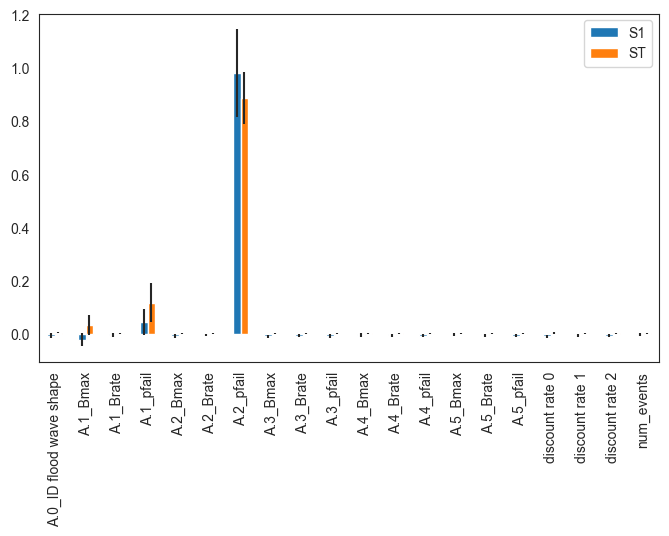

In [32]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = sobol_stats[['S1','ST']]
err = sobol_stats[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [33]:
exp,_=results

In [34]:
problem=get_SALib_problem(dike_model.uncertainties)

In [35]:
#Y = results
Y = outcomes[ooi][:,planning_step]
exp,_=results
n_exp = exp.shape[0]

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


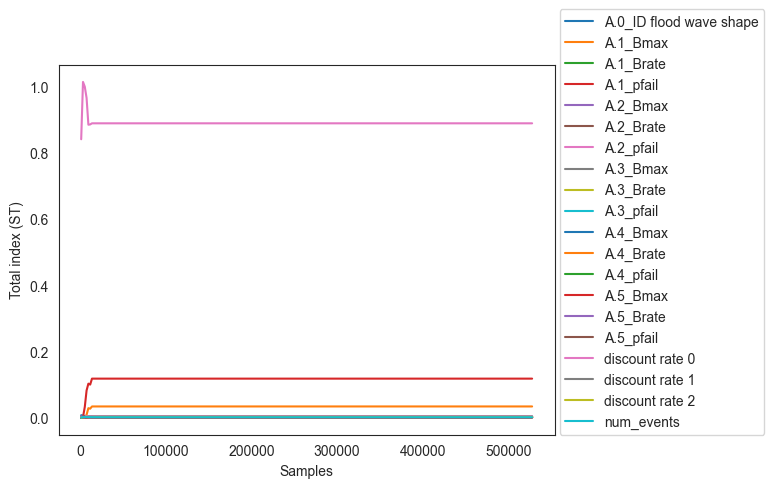

In [36]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
ax.legend(loc=(1.01,0))
plt.show()

### Analysing the Importance of different uncertainties under different policies

In [37]:
experiments.policy.unique()

['policy 1', 'policy 2', 'policy 3']
Categories (3, object): ['policy 1', 'policy 2', 'policy 3']

In [38]:
sobol_results = {}
problem = get_SALib_problem(dike_model.uncertainties)
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = outcomes[ooi][:,planning_step][logical]
    indices = sobol.analyze(problem, y)
    sobol_results[policy] = indices

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [51]:
axes[1]

<Axes: >

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


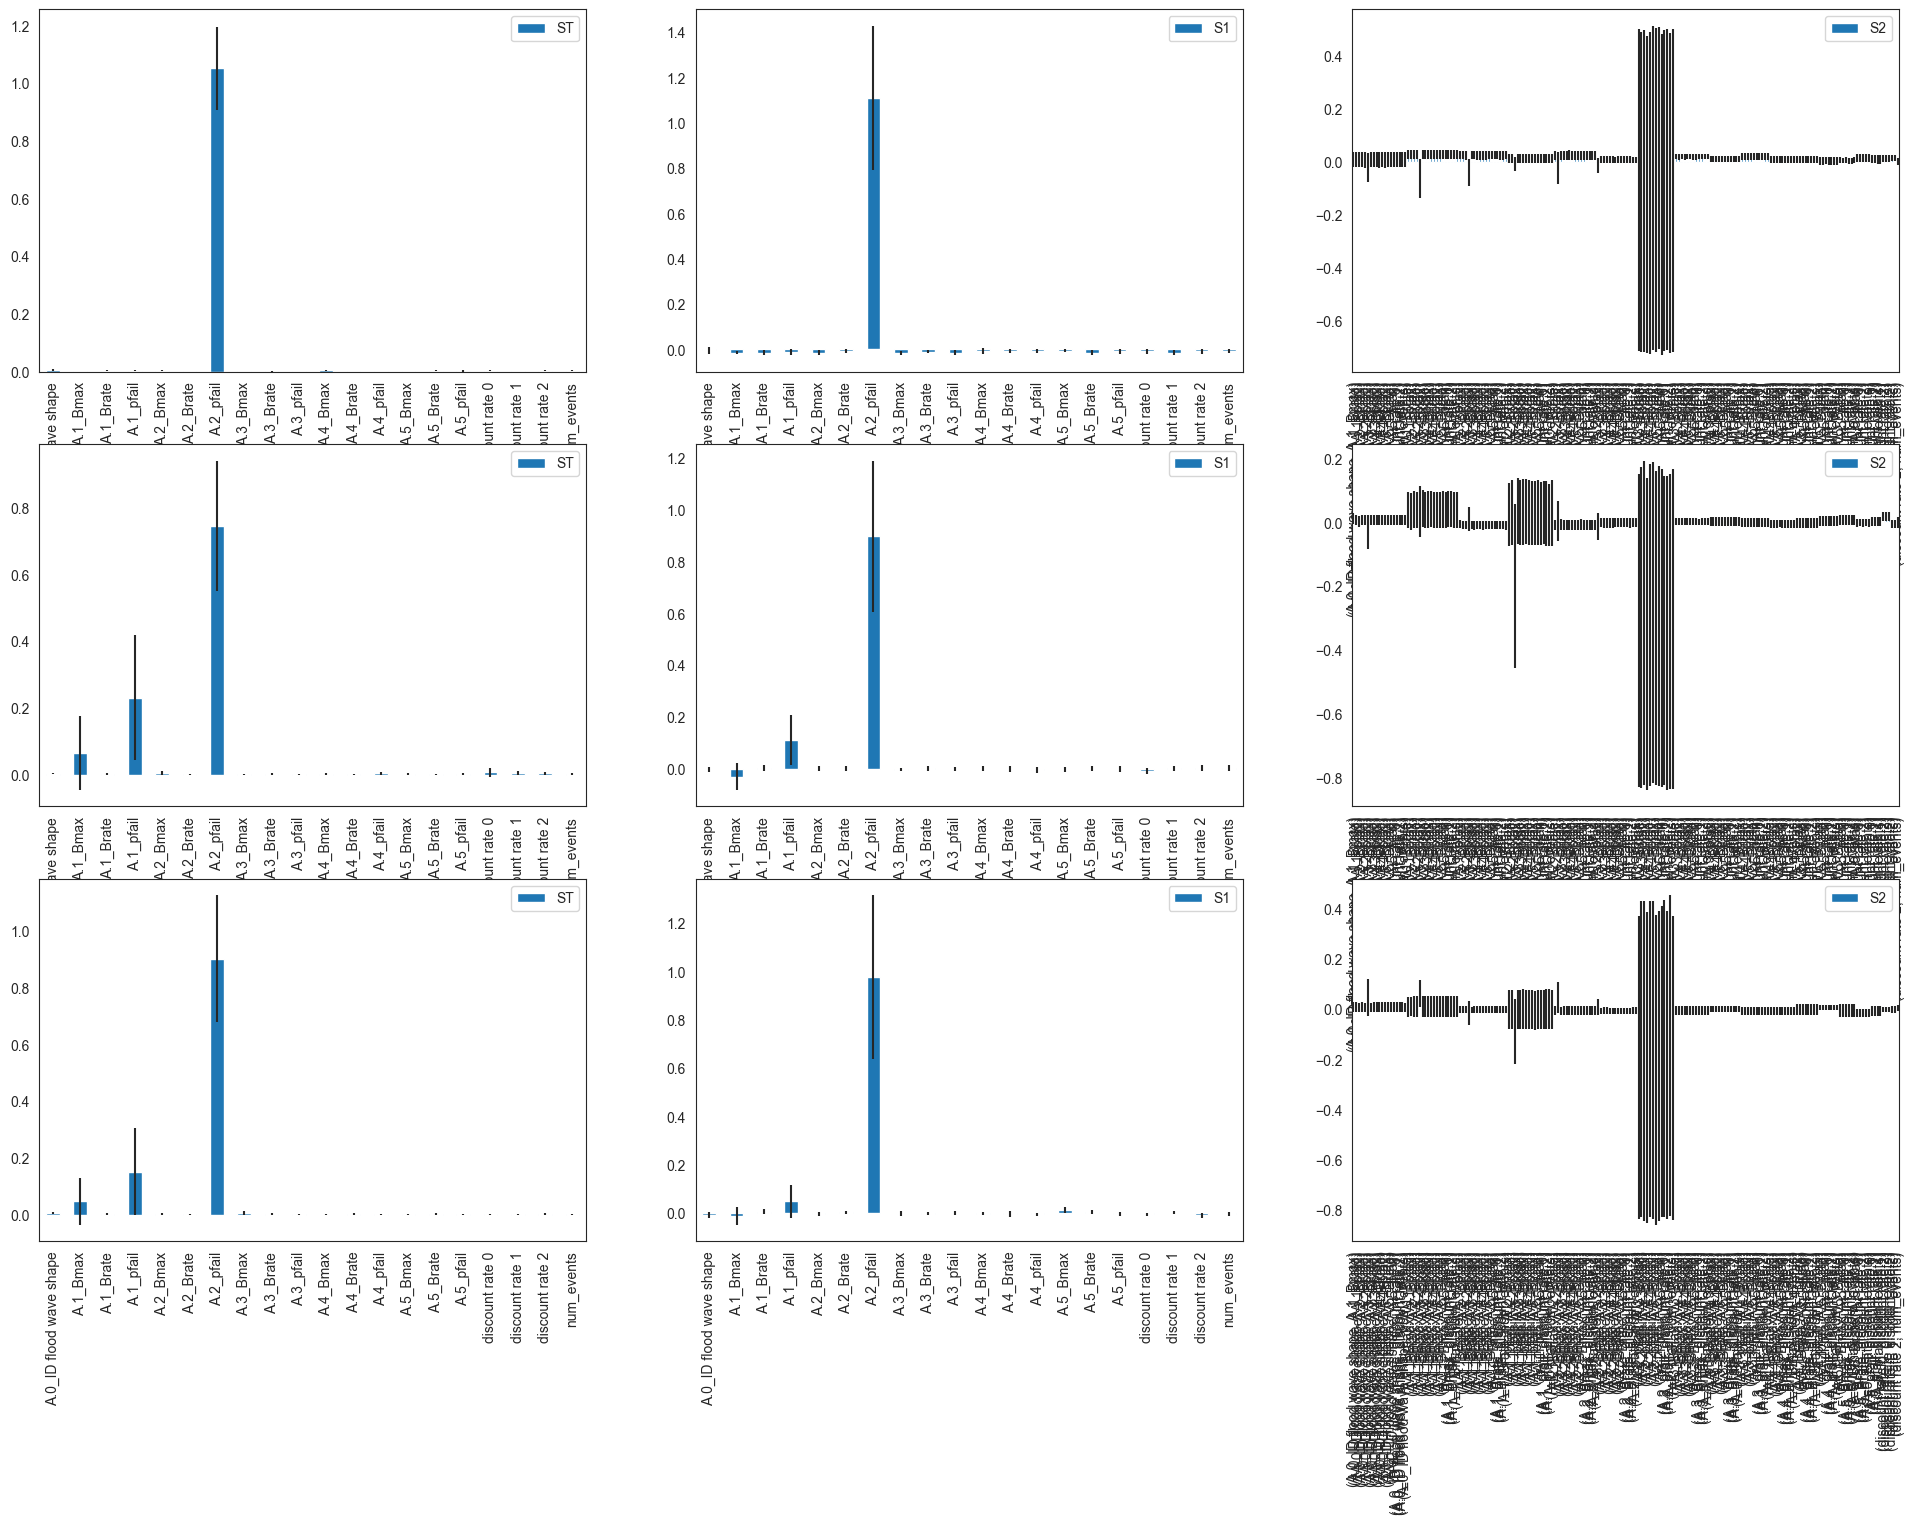

In [53]:
fig, axes = plt.subplots(3,3)
fig.set_size_inches(24, 16)
axes.flatten()

i=0
for policy in experiments.policy.unique():
    sobol_results[policy].plot(ax = axes[i])
    #plt.title(f"{policy}")
    i+=1

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

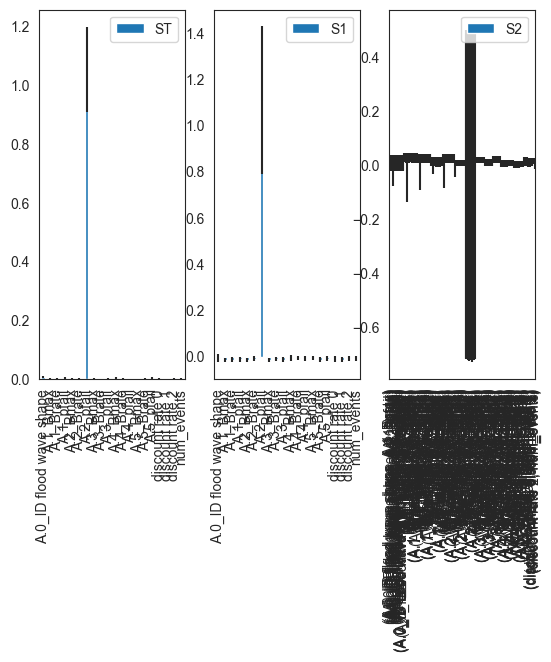

In [57]:
sobol_results['policy 1'].plot()